## Tutorial 1: The inputs and outputs of ZigZag
This tutorial guides you through a simple example of using ZigZag.

By the end of this tutorial, you will get a general idea of the inputs and output of ZigZag.

Let's define our own one-layer workload

In [1]:
workload = {
 0: {  # conv2_4 of resnet18
        'operator_type': 'Conv',
        'equation': 'O[b][k][oy][ox]+=W[k][c][fy][fx]*I[b][c][iy][ix]',
        'dimension_relations': ['ix=1*ox+1*fx', 'iy=1*oy+1*fy'],
        'loop_dim_size': {'B': 1, 'K': 64, 'C': 64, 'OY': 56, 'OX': 56, 'FY': 3, 'FX': 3},
        'operand_precision': {'O': 16, 'O_final': 8, 'W': 8, 'I': 8},
        'operand_source': {'W': [], 'I': []},
        'constant_operands': ['W'],
        'operand_source_dimension_mapping': {'I': {'IX': 'OX', 'IY': 'OY', 'C': 'K'}}
    }
}

Define the mapping

In [2]:
mapping = {
    "Conv": {
        "core_allocation": 1,
        "spatial_mapping": {'D1': ('K', 32), 'D2': ('C', 32)},
        "memory_operand_links": {'O': 'O', 'W': 'I2', 'I': 'I1'}
    }
}

Define our own HW architecture

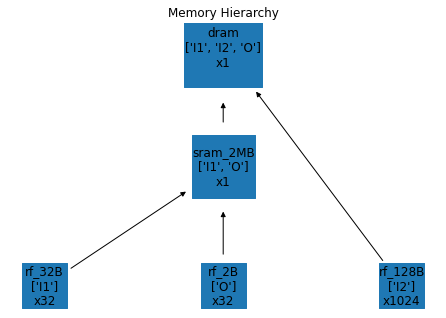

In [3]:
from zigzag.classes.hardware.architecture.memory_hierarchy import MemoryHierarchy
from zigzag.classes.hardware.architecture.operational_unit import Multiplier
from zigzag.classes.hardware.architecture.operational_array import MultiplierArray
from zigzag.classes.hardware.architecture.memory_instance import MemoryInstance
from zigzag.classes.hardware.architecture.accelerator import Accelerator
from zigzag.classes.hardware.architecture.core import Core

def memory_hierarchy_dut(multiplier_array):
    """Memory hierarchy variables"""
    ''' size=#bit, bw=(read bw, write bw), cost=(read word energy, write work energy) '''

    reg_2B = MemoryInstance(name="rf_2B", size=16, r_bw=16, w_bw=16, r_cost=0.021, w_cost=0.021, area=0,
                              r_port=2, w_port=2, rw_port=0, latency=1)

    reg_32B = MemoryInstance(name="rf_32B", size=32 * 8, r_bw=8, w_bw=8, r_cost=0.055, w_cost=0.055, area=0,
                            r_port=1, w_port=1, rw_port=0, latency=1)

    reg_128B = MemoryInstance(name="rf_128B", size=128 * 8, r_bw=8, w_bw=8, r_cost=0.095, w_cost=0.095, area=0,
                                r_port=1, w_port=1, rw_port=0, latency=1)

    sram_2M_with_16_128K_bank_128_1r_1w = \
        MemoryInstance(name="sram_2MB", size=131072 * 16 * 8, r_bw=128 * 16, w_bw=128 * 16, r_cost=26.01 * 16, w_cost=23.65 * 16, area=0,
                       r_port=1, w_port=1, rw_port=0, latency=1, min_r_granularity=64, min_w_granularity=64)

    dram = MemoryInstance(name="dram", size=10000000000, r_bw=64, w_bw=64, r_cost=500, w_cost=550, area=0,
                          r_port=0, w_port=0, rw_port=1, latency=1)

    memory_hierarchy_graph = MemoryHierarchy(operational_array=multiplier_array)

    '''
    fh: from high = wr_in_by_high
    fl: from low = wr_in_by_low
    th: to high = rd_out_to_high
    tl: to low = rd_out_to_low
    '''
    memory_hierarchy_graph.add_memory(memory_instance=reg_32B, operands=('I1',),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': None, 'th': None},),
                                      served_dimensions={(1, 0)})

    memory_hierarchy_graph.add_memory(memory_instance=reg_2B, operands=('O',),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': 'w_port_2', 'th': 'r_port_2'},),
                                      served_dimensions={(0, 1)})

    memory_hierarchy_graph.add_memory(memory_instance=reg_128B, operands=('I2',),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': None, 'th': None},),
                                      served_dimensions={(0, 0)})

    memory_hierarchy_graph.add_memory(memory_instance=sram_2M_with_16_128K_bank_128_1r_1w, operands=('I1', 'O'),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': None, 'th': None},
                                                  {'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': 'w_port_1', 'th': 'r_port_1'},),
                                      served_dimensions='all')

    memory_hierarchy_graph.add_memory(memory_instance=dram, operands=('I1', 'I2', 'O'),
                                      port_alloc=({'fh': 'rw_port_1', 'tl': 'rw_port_1', 'fl': None, 'th': None},
                                                  {'fh': 'rw_port_1', 'tl': 'rw_port_1', 'fl': None, 'th': None},
                                                  {'fh': 'rw_port_1', 'tl': 'rw_port_1', 'fl': 'rw_port_1', 'th': 'rw_port_1'},),
                                      served_dimensions='all')

    from zigzag.visualization.graph.memory_hierarchy import visualize_memory_hierarchy_graph
    visualize_memory_hierarchy_graph(memory_hierarchy_graph)
    return memory_hierarchy_graph


def multiplier_array_dut():
    """ Multiplier array variables """
    multiplier_input_precision = [8, 8]
    multiplier_energy = 0.04
    multiplier_area = 1
    dimensions = {'D1': 32, 'D2': 32}  # {'D1': ('K', 32), 'D2': ('C', 32)}

    multiplier = Multiplier(multiplier_input_precision, multiplier_energy, multiplier_area)
    multiplier_array = MultiplierArray(multiplier, dimensions)

    return multiplier_array


def cores():
    multiplier_array1 = multiplier_array_dut()
    memory_hierarchy1 = memory_hierarchy_dut(multiplier_array1)
    id = 1
    core1 = Core(id, multiplier_array1, memory_hierarchy1)
    return {core1}


cores = cores()
global_buffer = None
acc_name = 'our_own_accelerator'
accelerator = Accelerator(acc_name, cores, global_buffer)

Now, we have everything we need, let's set the output filenames and call ZigZag API function

In [4]:
# Set the filenames
dump_filename_pattern=f"outputs/Our_HW-single_layer_?.json"
pickle_filename = f"outputs/Our_HW-single_layer_cme.pickle"

In [5]:
# call ZigZag API function
from zigzag.api import get_hardware_performance_zigzag

energy, latency, cme = get_hardware_performance_zigzag(workload=workload,
                                                       accelerator=accelerator,
                                                       mapping=mapping,
                                                       opt='energy',
                                                       dump_filename_pattern=dump_filename_pattern,
                                                       pickle_filename=pickle_filename)

2023-02-09 12:32:45,821 - parse_workload_from_path_or_from_module +41 - INFO - Created workload graph with 1 nodes and 0 edges.
2023-02-09 12:32:45,822 - run +33 - INFO - Processing layer 0...
2023-02-09 12:32:45,822 - run +81 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 32), 'D2': ('C', 32)}.
2023-02-09 12:32:45,824 - run +82 - INFO - Running temporal mapping search engine...
100%|██████████| 720/720 [00:01<00:00, 449.23it/s]
2023-02-09 12:32:47,435 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_0, core=1) with energy 4.950e+07 and latency 1.649e+05 to outputs/Our_HW-single_layer_LayerNode_0_completeSave.json
2023-02-09 12:32:47,436 - run +97 - INFO - Saved CostModelEvaluation(layer=LayerNode_0, core=1) with energy 4.950e+07 and latency 1.649e+05 to outputs/Our_HW-single_layer_LayerNode_0_simpleSave.json
2023-02-09 12:32:47,440 - run +149 - INFO - Saved pickled list of 1 CMEs to outputs/Our_HW-single_layer_cme.pickle.


In [6]:
print(f"Total network energy = {energy:.2e} pJ")
print(f"Total network latency = {latency:.2e} cycles")

Total network energy = 4.95e+07 pJ
Total network latency = 1.65e+05 cycles


Let's have a look of the energy/latency breakdown.

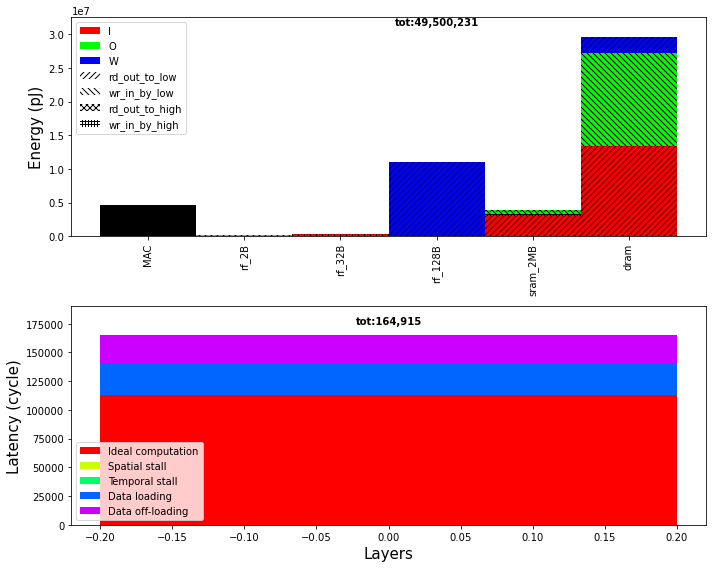

In [7]:
import pickle
from zigzag.visualization.results.plot_cme import bar_plot_cost_model_evaluations_breakdown

# Load in the pickled CME
with open(pickle_filename, 'rb') as fp:
    cme_for_the_single_layer = pickle.load(fp)

bar_plot_cost_model_evaluations_breakdown(cme_for_the_single_layer, save_path="plot_sinlg_layer_breakdown.png")

Let's have a look of the best temporal mapping found.

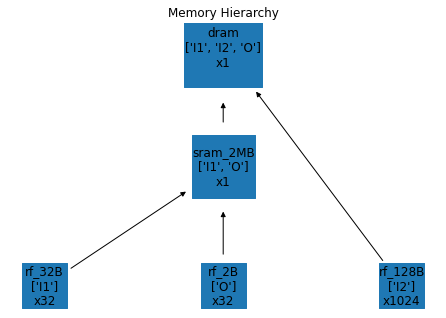


                                                                                 
******* Temporal Mapping - CostModelEvaluation(layer=LayerNode_0, core=1) *******
 O (O): [[('C', 2), ('FY', 3), ('FX', 3)], [('K', 2), ('OY', 56), ('OX', 56)], []]
 W (I2): [[('C', 2), ('FY', 3), ('FX', 3), ('K', 2), ('OY', 56), ('OX', 56)], []]
 I (I1): [[('C', 2), ('FY', 3), ('FX', 3), ('K', 2)], [('OY', 56), ('OX', 56)], []]
                                                                                 
---------------------------------------------------------------------------------
 Temporal Loops                 O                 W                 I            
---------------------------------------------------------------------------------
 for OX in [0:56)               sram_2MB          rf_128B           sram_2MB     
---------------------------------------------------------------------------------
  for OY in [0:56)              sram_2MB          rf_128B           sram_2MB     
------------

In [8]:
from zigzag.visualization.results.print_mapping import print_mapping
from zigzag.visualization.graph.memory_hierarchy import visualize_memory_hierarchy_graph

visualize_memory_hierarchy_graph(cme_for_the_single_layer[0].accelerator.cores[0].memory_hierarchy)
for cme in cme_for_the_single_layer:
    print_mapping(cme)